# Project Overview — “Can We Play?” for **Proven Data Private Limited**

# Setup & Importing necessary Libraries

## Company background

Proven Data Private Limited runs community leagues, coaching clinics, and weekend tournaments for football, tennis, and ultimate frisbee across 12 outdoor venues. Revenue is driven by scheduled sessions, equipment rentals, and concessions. Weather volatility creates last-minute cancellations, safety risks, and poor utilization of fields and staff.


## Problem statement

PDPL lacks a consistent, data-driven way to decide if conditions are suitable for outdoor sport. Coordinators rely on ad-hoc checks (weather apps + phone calls), leading to:

* Lost revenue from avoidable cancellations and under-booking.

* Safety incidents when play proceeds during poor conditions.

* Operational waste (staff travel, lights, groundskeeping) when sessions are canceled too late.


## Executive summary

Proven Data Private Limited will deploy a lightweight, supervised classification system to make consistent go/no-go decisions for outdoor sessions. By combining basic weather features with a deployable Streamlit app, PDPL expects fewer last-minute cancellations, safer play, and higher field utilization—while laying the groundwork for richer, forecast-driven scheduling in subsequent phases.

## Your Task 
We need a predictive system that classifies upcoming sessions as Play = Yes/No from weather conditions, with a simple interface for coordinators and coaches. The system should be accurate, fast, and auditable, and it should integrate into daily scheduling decisions. This is a Supervised Learning

In [212]:
## If running in a fresh environment, uncomment:
# %pip install pandas scikit-learn matplotlib joblib

import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)


# Loading the dataset

In [214]:
#load CSV File
df=pd.read_csv("my_weather_dataset.csv")
df.head(20)

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [218]:
df.tail()

,Outlook,Temperature,Humidity,Windy,Play
97,sunny,cool,NaN,NaN,NaN
98,rainy,cool,normall,True,NaN
99,NaN,hot,high,True,no
100,NaN,hot,high,True,YES
101,rainy,cool,NaN,True,no


# Exploring the dataset

In [220]:
#Shape of Data
df.shape

(102, 5)

* There are 102 rows and 5 columns in this dataset 

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Outlook      85 non-null     object
 1   Temperature  73 non-null     object
 2   Humidity     70 non-null     object
 3   Windy        72 non-null     object
 4   Play         77 non-null     object
dtypes: object(5)
memory usage: 4.1+ KB


In [224]:
#Checking for missing (null)values
df.isna().sum()

Outlook        17
Temperature    29
Humidity       32
Windy          30
Play           25
dtype: int64

In [226]:
#Check for duplicate values
df.duplicated().sum()

6

In [228]:
#Class Distribution
df['Temperature'].value_counts()

Temperature
mild     22
cool     21
hot      20
coool    10
Name: count, dtype: int64

In [230]:
df['Play'].value_counts()

Play
yes    25
no     20
YES    19
NO     13
Name: count, dtype: int64

In [232]:
df['Outlook'].value_counts()

Outlook
rainy       31
sunny       23
overcast    15
sunyy        8
Rainny       8
Name: count, dtype: int64

In [234]:
df['Humidity'].value_counts()

Humidity
high       31
normal     22
normall    17
Name: count, dtype: int64

In [236]:
df['Windy'].value_counts()

Windy
False    41
True     31
Name: count, dtype: int64

# Cleaning the dataset

In [238]:
#Standardize text to lower case
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

C:\Users\ekwum\AppData\Local\Temp\ipykernel_30552\3341676234.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [240]:
df.head(20)

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [242]:
df.tail(20)

,Outlook,Temperature,Humidity,Windy,Play
82,rainy,cool,NaN,False,yes
83,rainy,NaN,normall,False,yes
84,rainy,mild,normal,NaN,no
85,overcast,cool,NaN,False,no
86,rainny,coool,normall,False,NaN
87,rainy,coool,normall,NaN,NaN
88,rainny,cool,normal,True,no
89,NaN,coool,NaN,True,yes
90,rainny,NaN,normal,False,no
91,sunyy,mild,normall,True,NaN


In [244]:
df['Play'].value_counts()

Play
yes    44
no     33
Name: count, dtype: int64

In [246]:
#DROP DUPLICATES
df.drop_duplicates(inplace=True)

In [248]:
df.duplicated().sum()

0

In [250]:
# FILL MISSING VALUES
#for categorical variables we use mode to fill missing values while we use mean for numerical variables.

# Fill missing values if any (mode for categorical)
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)

C:\Users\ekwum\AppData\Local\Temp\ipykernel_30552\861676954.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\ekwum\AppData\Local\Temp\ipykernel_30552\861676954.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(df[col].mode()[0], inplac

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 101
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Outlook      96 non-null     object
 1   Temperature  96 non-null     object
 2   Humidity     96 non-null     object
 3   Windy        96 non-null     bool  
 4   Play         96 non-null     object
dtypes: bool(1), object(4)
memory usage: 3.8+ KB


In [254]:
# FIX TYPO ERRORS
# =========================
typo_corrections = {
    "Temperature": {
        "coool": "cool",
        "clod": "cool",
        "hottt": "hot",
        "mildd": "mild"
    },
    "Outlook": {
        "sunyy": "sunny",
        "rainny": "rainy",
        "overcst": "overcast"
    },
    "Humidity": {
        "hig": "high",
        "normall": "normal"
    }
}

for col, corrections in typo_corrections.items():
    df[col] = df[col].replace(corrections)


In [256]:
df['Outlook'].value_counts()

Outlook
rainy       55
sunny       27
overcast    14
Name: count, dtype: int64

In [258]:
df['Temperature'].value_counts()

Temperature
cool    58
mild    21
hot     17
Name: count, dtype: int64

In [260]:
df['Humidity'].value_counts()

Humidity
high      59
normal    37
Name: count, dtype: int64

# Define features/target

In [284]:
X=df.drop("Play",axis=1)

In [286]:
X

,Outlook,Temperature,Humidity,Windy
0,sunny,hot,high,False
1,sunny,hot,high,True
2,overcast,hot,high,False
3,rainy,mild,high,False
4,rainy,cool,normal,False
...,...,...,...,...
97,sunny,cool,high,False
98,rainy,cool,normal,True
99,rainy,hot,high,True
100,rainy,hot,high,True


In [288]:
y=df["Play"]

In [290]:
y

0       no
1       no
2      yes
3      yes
4      yes
      ... 
97     yes
98     yes
99      no
100    yes
101     no
Name: Play, Length: 96, dtype: object

In [292]:
categorical_features=X.columns.tolist()

In [294]:
categorical_features

['Outlook', 'Temperature', 'Humidity', 'Windy']

# Split the dataset into train and test sets

In [296]:
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.3,random_state=RANDOM_STATE,stratify=y
)

In [298]:
X_train

,Outlook,Temperature,Humidity,Windy
50,overcast,cool,normal,False
48,rainy,cool,high,False
89,rainy,cool,high,True
35,rainy,cool,high,True
5,rainy,cool,normal,True
...,...,...,...,...
59,rainy,cool,high,False
13,rainy,mild,high,True
33,overcast,hot,high,False
88,rainy,cool,normal,True


In [300]:
X_test

,Outlook,Temperature,Humidity,Windy
34,sunny,mild,normal,True
12,overcast,hot,normal,False
4,rainy,cool,normal,False
10,sunny,mild,normal,True
39,rainy,cool,normal,False
26,overcast,cool,high,False
77,overcast,cool,normal,True
68,overcast,mild,high,False
98,rainy,cool,normal,True
93,rainy,cool,high,False


In [302]:
y_train

50    yes
48    yes
89    yes
35    yes
5      no
     ... 
59    yes
13     no
33    yes
88     no
96     no
Name: Play, Length: 67, dtype: object

In [304]:
y_test

34     yes
12     yes
4      yes
10     yes
39     yes
26     yes
77      no
68      no
98     yes
93     yes
22      no
57     yes
70     yes
75      no
64     yes
66     yes
101     no
17      no
60     yes
81     yes
94      no
52      no
74     yes
6      yes
76     yes
28     yes
30     yes
91     yes
27      no
Name: Play, dtype: object

# Apply feature scaling (optional, appropriate for linear models)

In [306]:
# OneHotEncode categorical features, scale after encoding
preprocess = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
    ("scale", MaxAbsScaler())
])


# Train different models and make predictions

In [318]:
#Logistic Regression
logreg_model = Pipeline([("prep", preprocess), ("model", LogisticRegression(max_iter=1000))])
logreg_model.fit(X_train,y_train)
#logreg_model=logreg_model.predict(X_test)
acc_logreg=accuracy_score(y_test, logreg_model.predict(X_test))
acc_logreg


0.5517241379310345

In [330]:
# Decision Tree
tree_model = Pipeline([("prep", preprocess), ("model", DecisionTreeClassifier())])
tree_model.fit(X_train,y_train)
#tree_model=tree_model.predict(X_test)

Pipeline(steps=[('prep',
                 Pipeline(steps=[('ohe',
                                  OneHotEncoder(handle_unknown='ignore')),
                                 ('scale', MaxAbsScaler())])),
                ('model', DecisionTreeClassifier())])

In [332]:
acc_tree=accuracy_score(y_test,tree_model.predict(X_test))
acc_tree

0.5517241379310345

In [328]:
# Random Forest
rf_model = Pipeline([("prep", preprocess), ("model", RandomForestClassifier(n_estimators=200))])
rf_model.fit(X_train, y_train)
acc_rf=accuracy_score(y_test, rf_model.predict(X_test))
acc_rf

0.6206896551724138

In [336]:
# Linear SVM
svm_model = Pipeline([("prep", preprocess), ("model", LinearSVC())])
svm_model.fit(X_train, y_train)
acc_svm=accuracy_score(y_test, svm_model.predict(X_test))
acc_svm

0.5862068965517241

# Compare the results of model performance

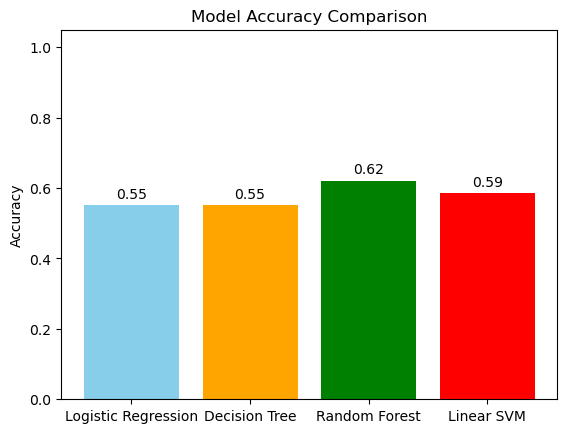

In [338]:
# Compare accuracies
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "Linear SVM"]
accuracies = [acc_logreg, acc_tree, acc_rf, acc_svm]

plt.bar(model_names, accuracies, color=["skyblue", "orange", "green", "red"])
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha="center")
plt.show()

# Select best perfoming model for use

Best Model: Random Forest (Accuracy: 0.62)

Classification Report:
              precision    recall  f1-score   support

          no       0.00      0.00      0.00         9
         yes       0.67      0.90      0.77        20

    accuracy                           0.62        29
   macro avg       0.33      0.45      0.38        29
weighted avg       0.46      0.62      0.53        29



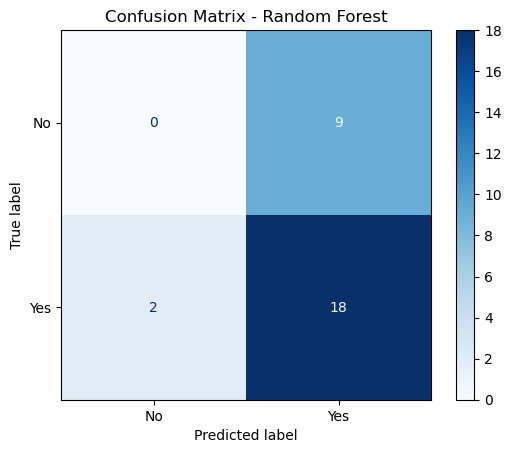

In [340]:
#Pick best model
best_index = np.argmax(accuracies)
best_model_name = model_names[best_index]
best_model = [logreg_model, tree_model, rf_model, svm_model][best_index]

print(f"Best Model: {best_model_name} (Accuracy: {accuracies[best_index]:.2f})")
y_pred_best = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best, labels=["no", "yes"])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"]).plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


# Save the model as a pickle file to be used on the streamlit app

In [342]:

#Save model
joblib.dump(best_model, ARTIFACTS_DIR / "best_weather_model.pkl")

# Convert NumPy types to native Python types for JSON
metadata = {
    col: sorted(df[col].dropna().unique().tolist())  # convert to list of Python objects
    for col in X.columns
}
with open(ARTIFACTS_DIR / "metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("Model and metadata saved in 'artifacts/' folder.")



Model and metadata saved in 'artifacts/' folder.
